In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#SAMPLING LAYER


In [2]:
class Sample(layers.Layer):
  def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [13]:
latent_dim=2

#VAE MODEL

In [15]:
class VAE(keras.Model):
  def __init__(self):
    super(VAE,self).__init__()

    #encoder
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sample()([z_mean, z_log_var])
    self.encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    
    #decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    self.decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

  def train_step(self, data):
    if isinstance(data, tuple):
        data = data[0]
    with tf.GradientTape() as tape:
      #latent mean and variance
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(data, reconstruction)
        )
        #loss function
        reconstruction_loss *= 28 * 28
        
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_mean(kl_loss)
        kl_loss *= -0.5

        total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
    }
    
    
        


In [18]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE()
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)


Epoch 1/30
547/547 [==============================] - 9s 17ms/step - loss: 207.9442 - reconstruction_loss: 206.5694 - kl_loss: 1.3748
Epoch 2/30
547/547 [==============================] - 9s 16ms/step - loss: 167.6381 - reconstruction_loss: 164.8430 - kl_loss: 2.7950
Epoch 3/30
547/547 [==============================] - 9s 17ms/step - loss: 157.1702 - reconstruction_loss: 154.0470 - kl_loss: 3.1231
Epoch 4/30
547/547 [==============================] - 9s 16ms/step - loss: 154.2223 - reconstruction_loss: 151.0141 - kl_loss: 3.2082
Epoch 5/30
547/547 [==============================] - 9s 16ms/step - loss: 152.4078 - reconstruction_loss: 149.1486 - kl_loss: 3.2593
Epoch 6/30
547/547 [==============================] - 9s 16ms/step - loss: 151.1136 - reconstruction_loss: 147.8070 - kl_loss: 3.3066
Epoch 7/30
547/547 [==============================] - 9s 16ms/step - loss: 150.1958 - reconstruction_loss: 146.8621 - kl_loss: 3.3336
Epoch 8/30
547/547 [==============================] - 9s 16ms/

#Visualising over latent space

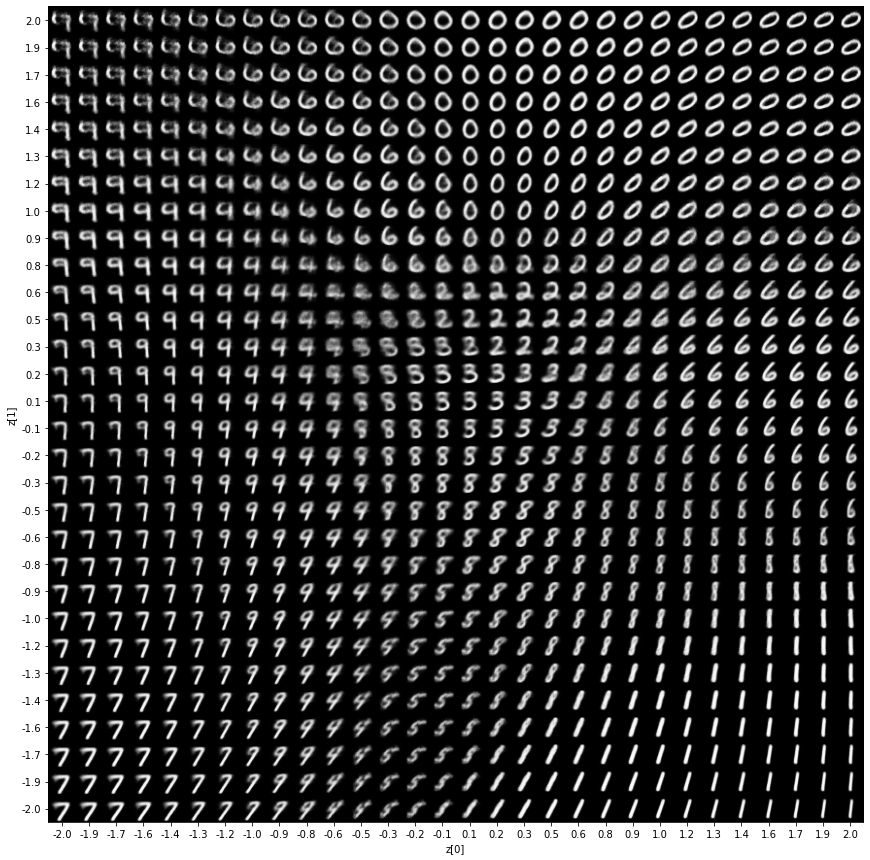

In [19]:
import matplotlib.pyplot as plt


def plot_latent( ):
    # display  digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
   
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent()